In [38]:
import torch
import torchvision
from torchvision import transforms
import pathlib
import importlib
from GeneratorEncoderTriplets.GAN import model
from matplotlib import pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
# checkpoint_dir = pathlib.Path('./GeneratorEncoderTriplets/weights/')
checkpoint_dir = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/checkpoints2')
test_images_dir = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/dataset/val')

In [40]:
generator = model.Generator(256, 64, w_hpf=0)
generator.load_state_dict(
    torch.load(
        pathlib.Path(checkpoint_dir / '037500_nets.ckpt'), map_location=DEVICE
        )['generator']
    )
style_encoder = model.StyleEncoder(256, 64, 3)
# style_encoder.load_state_dict(
#     torch.load(
#         pathlib.Path(checkpoint_dir / 'triplets_encoder.pth'), map_location=DEVICE
#         )
#     )
style_encoder.load_state_dict(
    torch.load(
        pathlib.Path(checkpoint_dir / '037500_nets.ckpt'), map_location=DEVICE
        )['style_encoder']
    )
generator.to(DEVICE)
style_encoder.to(DEVICE);

In [41]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])
source = torchvision.datasets.ImageFolder(test_images_dir / 'source', transform)
reference = torchvision.datasets.ImageFolder(test_images_dir / 'reference', transform)

In [42]:
source.classes, source[0][0].shape, reference.classes, reference[0][0].shape

(['normal'],
 torch.Size([3, 256, 256]),
 ['cancer', 'covid'],
 torch.Size([3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


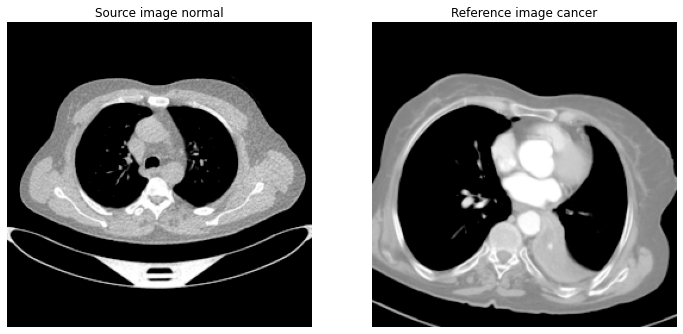

In [43]:
x, y = source[14]
x_ref, y_ref = reference[12]

plt.figure(figsize=(12, 9))
plt.subplot(1, 2, 1)
plt.title(f'Source image {source.classes[y]}')
plt.imshow(x.permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title(f'Reference image {reference.classes[y_ref]}')
plt.imshow(x_ref.permute(1, 2, 0))
plt.axis(False);

In [44]:
x, y = x.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y + 2])
x_ref, y_ref = x_ref.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y_ref])

In [45]:
with torch.inference_mode():
    style_encoder.eval()
    generator.eval()
    style_code = style_encoder(x_ref, y_ref)
    generated_image = generator(x, style_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


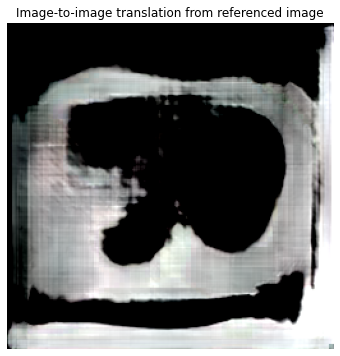

In [46]:
plt.figure(figsize=(9, 6))
plt.imshow(generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.title('Image-to-image translation from referenced image')
plt.axis(False);

In [47]:
with torch.inference_mode():
    style_encoder.eval()
    generator.eval()
    recon_style_code = style_encoder(x, y)
    recon_generated_image = generator(generated_image, recon_style_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


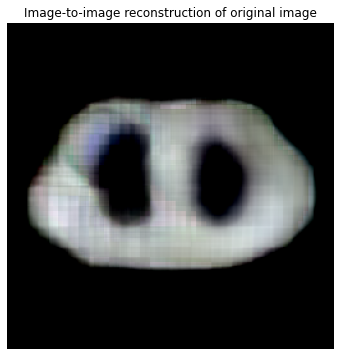

In [48]:
plt.figure(figsize=(9, 6))
plt.imshow(recon_generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.title('Image-to-image reconstruction of original image')
plt.axis(False);